In [ ]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

class TaskAllocationWithVariants:
    def __init__(self, robots, tasks, task_configs, capability_costs, task_rewards, max_coalition_size=5):
        """
        Initialize the task allocation problem with task variants.

        :param robots: List of robots, each with a vector of capabilities
        :param tasks: List of task IDs
        :param task_configs: Dictionary {task_id: [config1, config2,...]} where each config is a capability vector
        :param capability_costs: Vector of costs for each capability
        :param task_rewards: Dictionary {task_id: reward_value}
        :param max_coalition_size: Maximum number of robots in a coalition
        """
        self.robots = robots
        self.tasks = tasks
        self.task_configs = task_configs
        self.capability_costs = capability_costs
        self.task_rewards = task_rewards
        self.max_coalition_size = max_coalition_size
        self.H = len(capability_costs)

    def compute_utility(self, coalition, config, task_id):
        """
        Compute utility of assigning coalition to task configuration.
        Utility = reward - sum(capability costs) - coordination cost
        """
        # Checking if coalition satisfies config requirements
        total_cap = np.sum([self.robots[r] for r in coalition], axis=0)
        if np.any(total_cap < config):
            return 0
        # Computing  utility
        utility = self.task_rewards[task_id]
        utility -= np.dot(config, self.capability_costs)
        utility -= 4 * len(coalition)
        return utility

    def generate_all_assignments(self):
        """Generate all possible valid assignments (coalition, config, task_id, utility)"""
        assignments = []

        all_coalitions = []
        for size in range(1, self.max_coalition_size + 1):
            all_coalitions.extend(itertools.combinations(range(len(self.robots)), size))

        # Generate all possible assignments
        for task_id in self.tasks:
            for config in self.task_configs[task_id]:
                for coalition in all_coalitions:
                    utility = self.compute_utility(coalition, config, task_id)
                    if utility > 0:
                        assignments.append({
                            'coalition': coalition,
                            'config': config,
                            'task_id': task_id,
                            'utility': utility
                        })
        return assignments

    def flat_max_util(self):
        """Greedy algorithm that selects maximum utility assignments first"""
        assignments = self.generate_all_assignments()
        assignments.sort(key=lambda x: x['utility'], reverse=True)

        selected = []
        used_robots = set()
        used_tasks = set()

        for a in assignments:
            if (not any(r in used_robots for r in a['coalition'])) and (a['task_id'] not in used_tasks):
                selected.append(a)
                used_robots.update(a['coalition'])
                used_tasks.add(a['task_id'])

        return selected

    def flat_rc(self):
        """Resource-Centric greedy algorithm considering assignment influences"""
        assignments = self.generate_all_assignments()
        selected = []
        used_robots = set()
        used_tasks = set()

        while len(assignments) > 0:
            # Compute resource-centric metric for each assignment
            for i, a in enumerate(assignments):
                influence = 0
                for other in assignments:
                    if (any(r in a['coalition'] for r in other['coalition']) or
                        other['task_id'] == a['task_id']):
                        influence += other['utility']

                assignments[i]['rc_metric'] = a['utility'] - influence

            assignments.sort(key=lambda x: x['rc_metric'], reverse=True)
            best = assignments[0]

            if (not any(r in used_robots for r in best['coalition']) and
                best['task_id'] not in used_tasks):
                selected.append(best)
                used_robots.update(best['coalition'])
                used_tasks.add(best['task_id'])

            assignments = [
                a for a in assignments
                if not any(r in best['coalition'] for r in a['coalition'])
                and a['task_id'] != best['task_id']
            ]

        return selected

    def random_baseline(self):
        """Randomly select a configuration for each task, then run FlatMaxUtil"""
        # Randomly select one config per task
        reduced_configs = {
            task_id: [self.task_configs[task_id][np.random.randint(len(self.task_configs[task_id]))]]
            for task_id in self.tasks
        }

        reduced_problem = TaskAllocationWithVariants(
            self.robots, self.tasks, reduced_configs,
            self.capability_costs, self.task_rewards, self.max_coalition_size
        )

        return reduced_problem.flat_max_util()

def generate_random_problem(num_robots, num_tasks, max_configs_per_task=3, H=5):
    """Generate a random problem instance following paper's parameters"""
    capability_costs = np.random.uniform(0.0, 1.0, H)

    robots = []
    for _ in range(num_robots):
        capabilities = np.zeros(H)
        for h in range(H):
            if np.random.random() < 0.5:
                capabilities[h] = np.random.uniform(0, 8)
        robots.append(capabilities)

    tasks = list(range(num_tasks))
    task_rewards = {t: np.random.uniform(100, 150) for t in tasks}

    task_configs = {}
    for t in tasks:
        num_configs = np.random.randint(1, max_configs_per_task + 1)
        configs = []
        for _ in range(num_configs):
            config = np.zeros(H)
            for h in range(H):
                if np.random.random() < 0.5:
                    config[h] = np.random.uniform(0, 8)
            configs.append(config)
        task_configs[t] = configs

    return TaskAllocationWithVariants(
        robots, tasks, task_configs, capability_costs, task_rewards
    )

def evaluate_algorithm(problem, algorithm, num_runs=5):
    """Evaluate an algorithm on a problem instance"""
    utilities = []
    times = []

    for _ in range(num_runs):
        start_time = time.time()
        if algorithm == 'random':
            assignments = problem.random_baseline()
        elif algorithm == 'flat_max_util':
            assignments = problem.flat_max_util()
        elif algorithm == 'flat_rc':
            assignments = problem.flat_rc()
        else:
            raise ValueError("Unknown algorithm")

        elapsed = time.time() - start_time
        total_utility = sum(a['utility'] for a in assignments)

        utilities.append(total_utility)
        times.append(elapsed)

    return np.mean(utilities), np.mean(times)

def compute_upper_bound(problem):
    """Compute upper bound as sum of max utility per task (without conflicts)"""
    max_utilities = []

    for task_id in problem.tasks:
        max_utility = 0
        for config in problem.task_configs[task_id]:
            best_utility = 0
            # Generate all possible coalitions
            for size in range(1, problem.max_coalition_size + 1):
                for coalition in itertools.combinations(range(len(problem.robots)), size):
                    utility = problem.compute_utility(coalition, config, task_id)
                    if utility > best_utility:
                        best_utility = utility
            if best_utility > max_utility:
                max_utility = best_utility
        max_utilities.append(max_utility)

    return sum(max_utilities)

Varying robots: 100%|██████████| 6/6 [2:31:47<00:00, 1517.99s/it]


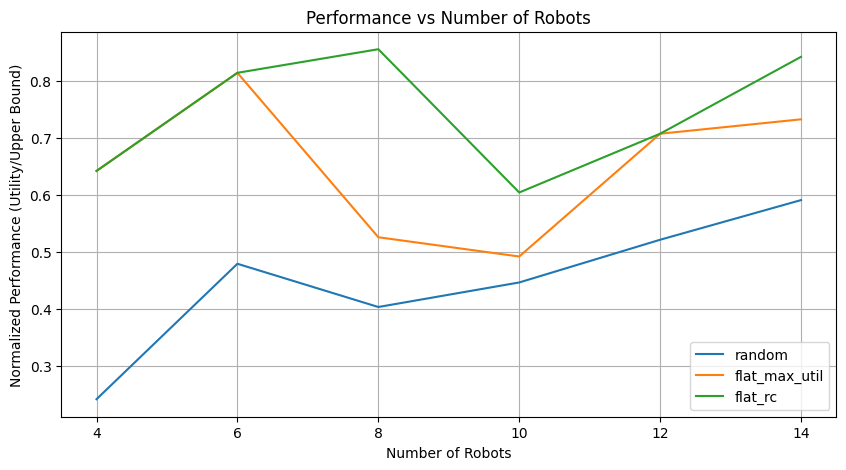

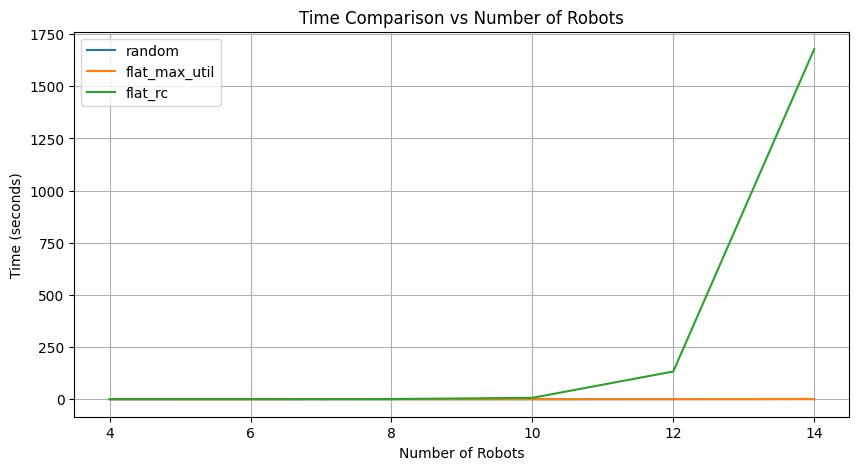

In [25]:


def run_experiment_vary_robots(num_tasks=7, max_configs=5, num_runs=5):
    """Run experiment varying number of robots (Figure 2 and 3)"""
    robot_counts = range(4, 15, 2)
    algorithms = ['random', 'flat_max_util', 'flat_rc']

    results = {alg: {'performance': [], 'time': []} for alg in algorithms}
    upper_bounds = []

    for num_robots in tqdm(robot_counts, desc="Varying robots"):
        # Generate problem instance
        problem = generate_random_problem(num_robots, num_tasks, max_configs)
        ub = compute_upper_bound(problem)
        upper_bounds.append(ub)

        for alg in algorithms:
            mean_utility, mean_time = evaluate_algorithm(problem, alg, num_runs)
            results[alg]['performance'].append(mean_utility / ub)
            results[alg]['time'].append(mean_time)

    plt.figure(figsize=(10, 5))
    for alg in algorithms:
        plt.plot(robot_counts, results[alg]['performance'], label=alg)
    plt.xlabel('Number of Robots')
    plt.ylabel('Normalized Performance (Utility/Upper Bound)')
    plt.title('Performance vs Number of Robots')
    plt.legend()
    plt.grid(True)
    plt.savefig('performance_vs_robots.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    for alg in algorithms:
        plt.plot(robot_counts, results[alg]['time'], label=alg)
    plt.xlabel('Number of Robots')
    plt.ylabel('Time (seconds)')
    plt.title('Time Comparison vs Number of Robots')
    plt.legend()
    plt.grid(True)
    plt.savefig('time_vs_robots.png')
    plt.show()

    return results

experiment_results = run_experiment_vary_robots()